In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
import warnings
warnings.filterwarnings("ignore")

In [2]:
# OIS
ois = pd.read_pickle('Odisc')
# FSR
FSR = pd.read_pickle('FSR')
# LDR
ldr = pd.read_pickle('Ldisc')
# SABR
SABRdf = pd.read_pickle('SABRdf')
DDdf = pd.read_pickle('DD_Calibration')

In [3]:
def greek_interpolator(SABRdf, DDdf, t, T, Tenor, freq = 2):
    gap = int((T-t)*freq+1)
    Tenor = int(Tenor)
    df = pd.DataFrame({'Expiry':np.linspace(t, T, gap),'Tenor': [Tenor]*gap,'Alpha': np.NaN,
                       'Rho': np.NaN, 'Nu': np.NaN, 'Beta': np.NaN, 'Sigma': np.NaN})
    SABRcol, DDcol = ['Alpha', 'Rho', 'Nu'], ['Beta', 'Sigma']
    m1 = DDdf[DDdf['Tenor']==Tenor]
    m2 = m1[m1['Expiry'] <= T].reset_index(drop=True)
    m1s= SABRdf[SABRdf['Tenor']==Tenor]
    m2s= m1s[m1s['Expiry'] <= T].reset_index(drop=True)
    df.loc[[0,gap-1],SABRcol] = m2s.iloc[[0,-1],:].loc[:,SABRcol].values
    df.loc[[0,gap-1],DDcol] = m2.iloc[[0,-1],:].loc[:,DDcol].values
    df = df.interpolate()
    return df

def greek_concatenator(SABRdf, DDdf, t, middle, T, Tenor, freq = 2):
    df1 = greek_interpolator(SABRdf,DDdf,t,middle,Tenor,freq)
    df2 = greek_interpolator(SABRdf,DDdf,middle,T,Tenor,freq)
    dfc = pd.concat([df1,df2[1:]],axis = 0)
    dfc.reset_index(inplace=True,drop=True)
    return dfc

def extrapolator(data, tenor, delta):
    if delta == 0.5:
        data.loc[len(data)+1] = [0, tenor, 0, 0 ,0 ,0, 0]
        data.loc[len(data)+2] = [delta, tenor, data.iloc[1,2]/2, data.iloc[1,3]/2 ,data.iloc[1,4]/2 ,data.iloc[1,5]/2, data.iloc[1,6]/2]
        data = data.sort_values(by = "Expiry").reset_index(drop = True)
        return data.tail(-1)
    elif delta == 0.25:
        data.loc[len(data)+1] = [0, tenor, 0, 0 ,0 ,0, 0]
        data.loc[len(data)+2] = [delta, tenor, data.iloc[1,2] * 1/4, data.iloc[1,3] * 1/4 ,data.iloc[1,4] * 1/4 ,data.iloc[1,5] * 1/4, data.iloc[1,6]* 1/4]
        data.loc[len(data)+3] = [delta*2, tenor, data.iloc[1,2] * 1/2, data.iloc[1,3] * 1/2 ,data.iloc[1,4] * 1/2 ,data.iloc[1,5] * 1/2, data.iloc[1,6] * 1/2]
        data.loc[len(data)+3] = [delta*3, tenor, data.iloc[1,2] * 3/4, data.iloc[1,3] * 3/4 ,data.iloc[1,4] * 3/4 ,data.iloc[1,5] * 3/4, data.iloc[1,6] * 3/4]
        data = data.sort_values(by = "Expiry").reset_index(drop = True)
        return data.tail(-1)

In [4]:
def Black76Lognormal(F, K, T, r, sigma, opt):
    d1 = (log(F/K)+(sigma*sigma/2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    if opt == 'Call':
        return F*exp(-r*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)
    elif opt == 'Put':
        return K*exp(-r*T)*norm.cdf(-d2) - F*exp(-r*T)*norm.cdf(-d1)

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [5]:
#forward LIBOR from discount factor
def F_LIBOR(D1,D2,delta):
    forward_LIBOR = (1/delta)*((D1-D2)/D2)
    return forward_LIBOR

def OISDF(T):
    x = list(ois['Tenor'])
    y = list(ois['Discount'])
    return np.interp(T, x, y)

def LIBORDF(T):
    x = list(ldr['Tenor'])
    y = list(ldr['Discount'])
    return np.interp(T, x, y)

In [6]:
def Forward_SWAP_RATE(expiry, tenor, delta):
    month = int(tenor/delta)#number of payment after during tenor period
    float_leg, fixed_leg = 0, 0 #initialize fix and floating leg

    for i in range(1,month+1):
        loc = expiry + i*delta
        # float leg = OIS discount factor x forward LIBOR x delta
        float_leg += OISDF(loc)*F_LIBOR(LIBORDF(loc-delta),LIBORDF(loc),delta)*delta

    for i in range(1,month+1):
        # Fixed leg = Sum of OIS discount factor from Expiry to Tenor end
        fixed_leg += OISDF(expiry + i*delta)*delta

    return float_leg/fixed_leg

In [7]:
def IRR(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += Delta*(1 + K* Delta)**(-i)
    return total

def IRR_1st(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(Delta**2)*(1 + K* Delta)**(-i-1)
    return total

def IRR_2nd(Tenor, Delta, K):
    total = 0
    for i in np.arange(1, Tenor/Delta +1):
        total += (-i)*(-i-1)*(Delta**3)*(1 + K* Delta)**(-i-2)
    return total

In [8]:
def h_2nd(Tenor, Delta, K):
    IRR0 = IRR(Tenor, Delta, K)
    IRR1 = IRR_1st(Tenor, Delta, K)
    IRR2 = IRR_2nd(Tenor, Delta, K)
    return (-IRR2*K - 2*IRR1) / (IRR0**2) + 2*(IRR1**2)*K/(IRR0**3)

In [9]:
def integrand(F, K, T, r, sigma, tenor, delta, opt):
    irr = IRR(tenor, delta, F)
    h_2 = h_2nd(tenor, delta, K)
    return h_2*Black76Lognormal(F, K, T, r, sigma, opt)


def CMS(expiry, tenor, delta):
    F       = Forward_SWAP_RATE(expiry, tenor, delta)
    greeks_sabr = extrapolator(greek_concatenator(SABRdf, DDdf, 1, 5, 10, 10,freq = 1/delta), 10, delta)
    alpha   = greeks_sabr.loc[int(expiry*(1/delta)), "Alpha"]
    rho     = greeks_sabr.loc[int(expiry*(1/delta)), "Rho"]
    nu      = greeks_sabr.loc[int(expiry*(1/delta)), "Nu"]
    VRec     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Put'), 0, F)
    VPay     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Call'), F, 0.1)
    return F + VRec[0] + VPay[0]

In [10]:
def PV_CMS(tenor, cms_period, delta):
    n = int(cms_period/delta)
    pv = 0
    for i in range(1,n+1):
        loc = i*delta
        pv += OISDF(loc)*delta*CMS(loc,tenor,delta)
    return pv

In [11]:
cms_period, tenor, delta = 5, 10, 0.5

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS10y semi-annually over the next 5 years = ',PV )

PV of a leg receiving CMS10y semi-annually over the next 5 years =  0.20206740368145049


In [12]:
cms_period, tenor, delta = 10 , 2, 0.25

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS2y quarterly over the next 10 years = ',PV )

PV of a leg receiving CMS2y quarterly over the next 10 years =  0.37916548178984566


In [13]:
#calculate CMS rates
Exipry = [1, 5, 10]
Tenor = [1, 2, 3, 5, 10]
delta = 0.5

CMS_list = []
for i in Exipry:
    for j in Tenor:
        CMS_list.append(CMS(i,j,delta))

In [14]:
Expiry, Tenor = FSR.iloc[ : ,0], FSR.iloc[ : ,1]
table = pd.DataFrame({'Expiry':Expiry,'Tenor':Tenor, 'CMS': CMS_list, 'Forward Swap Rate': FSR["FSR"].values})
table["difference"] = [None] * len(table)
for i in range(len(table)):
    table["difference"][i] = table["CMS"][i] - table["Forward Swap Rate"][i]
table

,Expiry,Tenor,CMS,Forward Swap Rate,difference
0,1,1,0.032065,0.032007,0.000058
1,1,2,0.033312,0.033259,0.000052
2,1,3,0.034063,0.034011,0.000052
3,1,5,0.035309,0.035255,0.000054
4,1,10,0.038494,0.038428,0.000066
5,5,1,0.039695,0.039274,0.000421
6,5,2,0.040444,0.040075,0.00037
7,5,3,0.040425,0.040072,0.000352
8,5,5,0.041454,0.041093,0.00036
9,5,10,0.044051,0.043634,0.000417


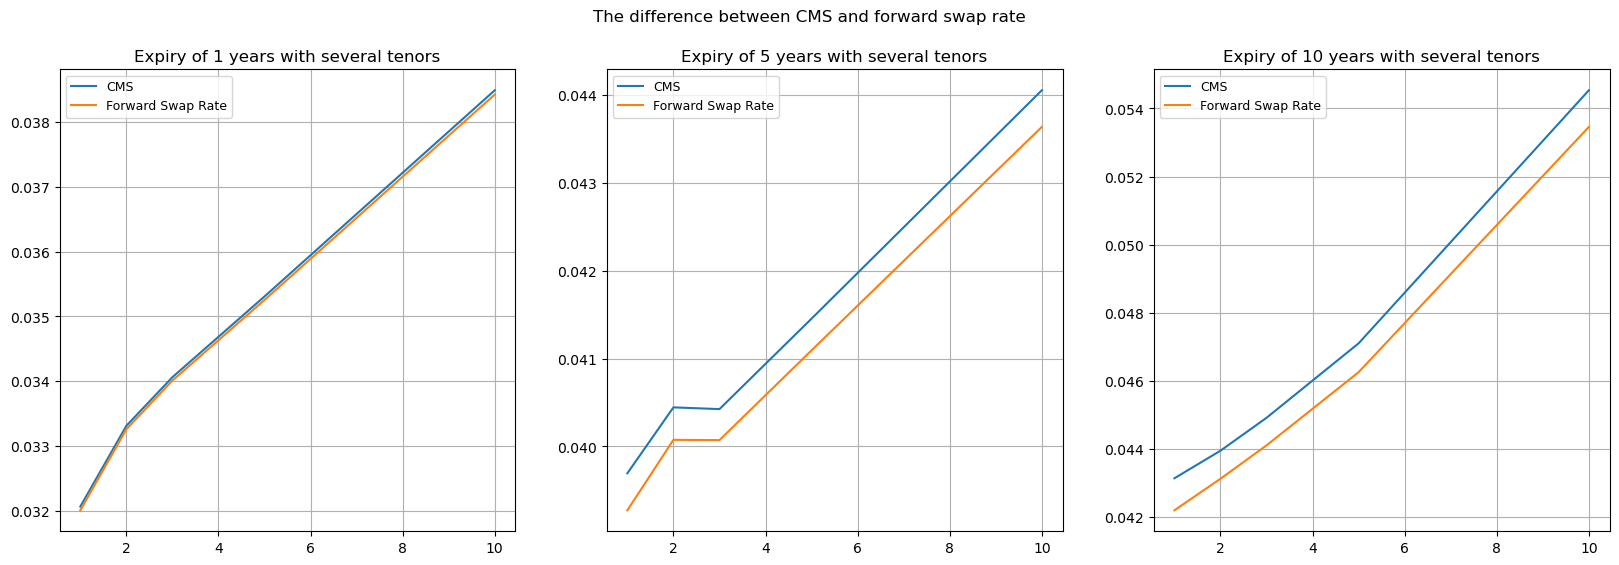

In [15]:
expiry_1y, expiry_5y, expiry_10y = table[ :5], table[5 : 10], table[10 :]
fig, ((ax1, ax2, ax3)) = plt.subplots(figsize = (20, 6), nrows=1, ncols=3)
fig.suptitle('The difference between CMS and forward swap rate')
    
ax1.plot(table[ :5]["Tenor"], expiry_1y.iloc[ : ,2], label='CMS')
ax1.plot(table[ :5]["Tenor"], expiry_1y.iloc[ : ,3], label='Forward Swap Rate')
ax1.set_title("Expiry of 1 years with several tenors")
ax1.grid(visible = True)
ax1.legend(loc="upper left", fontsize = 9)

ax2.plot(table[ :5]["Tenor"], expiry_5y.iloc[ : ,2], label='CMS')
ax2.plot(table[ :5]["Tenor"], expiry_5y.iloc[ : ,3], label='Forward Swap Rate')
ax2.set_title("Expiry of 5 years with several tenors")
ax2.grid(visible = True)
ax2.legend(loc="upper left", fontsize = 9)

ax3.plot(table[ :5]["Tenor"], expiry_10y.iloc[ : ,2], label='CMS')
ax3.plot(table[ :5]["Tenor"], expiry_10y.iloc[ : ,3], label='Forward Swap Rate')
ax3.set_title("Expiry of 10 years with several tenors")
ax3.grid(visible = True)
ax3.legend(loc="upper left", fontsize = 9)
plt.show()